### Competition Model

$$u' = u(1 - a_1  u - a_2  v)$$
$$v' = rv(1 -b_1 u - b_2 v)$$
with $u_0 = 2$ and $v_0 = 1$

##### Workflow Overview

1. Define the **problem domain**, by using the `fbpinns.domains.RectangularDomainND` class
2. Define the **ODE** to solve, and its **problem constraints**, by defining our own `fbpinns.problems.Problem` class
3. Define the **domain decomposition** used by the FBPINN, by using the `fbpinns.decompositions.RectangularDecompositionND` class
4. Define the **neural network** placed in each subdomain, by using the `fbpinns.networks.FCN` class
5. Pass these classes and their initialisation values to a `fbpinns.constants.Constants` object
6. Start the FBPINN training by instantiating a `fbpinns.trainer.FBPINNTrainer` using the `Constants` object.

##### Step 1: Problem Domain

In [1]:
import sys
import os

# Paths you want to add to sys.path
paths_to_add = [
    os.path.abspath(os.path.join('../..')),  
    os.path.abspath(os.path.join('..'))  
]

sys.path.extend(path for path in paths_to_add if path not in sys.path)


In [2]:
import numpy as np
from fbpinns.domains import RectangularDomainND

domain = RectangularDomainND
domain_init_kwargs = dict(
    xmin = np.array([0.,]),
    xmax = np.array([24.,])
)

domain_init_kwargs

{'xmin': array([0.]), 'xmax': array([24.])}

Step 2: Define the ODE to solve

In [3]:
import jax.numpy as jnp
from fbpinns.problems import Problem

In [4]:
from scipy.integrate import odeint
from scipy.interpolate import interp1d
import jax

class CompetitionModel(Problem):

    @staticmethod
    def init_params(params=[0.5, 0.7, 0.3, 0.3, 0.6], u0=2, v0=1, sd=0.1):
        
        r, a1, a2, b1, b2 = params 
        static_params = {
            "dims":(2,1),   # dims of solution and problem
            "r_true":r,
            "a1_true":a1,
            "a2_true":a2,
            "b1_true":b1,
            "b2_true":b2,
            "u0":u0,
            "v0":v0,
            "sd":sd,
        }
        trainable_params = {
            "r":jnp.array(0.),
            "a1":jnp.array(0.),
            "a2":jnp.array(0.),
            "b1":jnp.array(0.),
            "b2":jnp.array(0.),
        }
        return static_params, trainable_params
    
    @staticmethod
    def sample_constraints(all_params, domain, key, sampler, batch_shapes):
        # Physics Loss
        x_batch_phys = domain.sample_interior(all_params, key, sampler, batch_shapes[0])
        required_ujs_phys = (
            (0, ()),  
            (1, ()),  
            (0, (0,)), 
            (1, (1,)),  
        )

        # Data Loss
        u0 = all_params["static"]["problem"]["u0"]
        v0 = all_params["static"]["problem"]["v0"]
        x_batch_data = jnp.linspace(10, 24, 100).astype(float).reshape((-1,1))
        # r_true, a1_true, a2_true, b1_true, b2_true = [all_params['static']["problem"][key] for key in ('r_true', 'a1_true', 'a2_true', 'b1_true', 'b2_true')]
        # params = (r_true, a1_true, a2_true, b1_true, b2_true)
        # solution = odeint(CompetitionModel.model, [u0,v0], x_batch_data.reshape((-1,)), args=(params,))
        noise = jax.random.normal(key, shape=(x_batch_data.shape[0],1))  * 0.05
        solution = CompetitionModel.exact_solution(all_params, x_batch_data)
        u_data = solution[:,0] + noise
        v_data = solution[:,1] + noise
        required_ujs_data = (
            (0, ()), 
            (1, ()),  
        )


        return [[x_batch_phys, required_ujs_phys],
                [x_batch_data, u_data, v_data, required_ujs_data]]
    
    @staticmethod
    def constraining_fn(all_params, x_batch, solution):
        sd = all_params["static"]["problem"]["sd"]
        u0 = all_params["static"]["problem"]["u0"]
        v0 = all_params["static"]["problem"]["v0"]

        x, tanh = x_batch[:,0:1], jnp.tanh

        u = solution[:, 0:1] * tanh(x/sd) + u0 # Hard constraining
        v = solution[:, 1:2] * tanh(x/sd)  + v0

        return jnp.concatenate([u, v], axis=1)
    
    @staticmethod
    def loss_fn(all_params, constraints):
        
        r, a1, a2, b1, b2 = [all_params['trainable']["problem"][key] for key in ('r', 'a1', 'a2', 'b1', 'b2')]

        # Physics loss
        _, u, v, ut, vt = constraints[0]
        phys1 = jnp.mean((ut - u + a1*u**2 + a2*u*v)**2)
        phys2 = jnp.mean((vt - r*v + r*b1*u*v + r*b2*v**2)**2)
        phys = phys1 + phys2

        # Data Loss
        _, ud, vd, u, v = constraints[1]
        u = u.reshape(-1) 
        v = v.reshape(-1) 
        data = jnp.mean((u-ud)**2) + jnp.mean((v-vd)**2)
        
        return phys + data

    @staticmethod
    def model(y, t, params):
        """
        Compute the derivatives of the system at time t.
        
        :param y: Current state of the system [u, v].
        :param t: Current time.
        :param params: Parameters of the model (a1, a2, b1, b2, r).
        :return: Derivatives [du/dt, dv/dt].
        """
        u, v = y  
        r, a1, a2, b1, b2 = params  
        
        # Define the equations
        du_dt = u * (1 - a1 * u - a2 * v)
        dv_dt = r * v * (1 - b1 * u - b2 * v)
        
        return [du_dt, dv_dt]
    
    @staticmethod
    def exact_solution(all_params, x_batch, batch_shape=None):
        r, a1, a2, b1, b2 = [all_params['static']["problem"][key] for key in ('r_true', 'a1_true', 'a2_true', 'b1_true', 'b2_true')]
        u0 = all_params["static"]["problem"]["u0"]
        v0 = all_params["static"]["problem"]["v0"]
        params = [r, a1, a2, b1, b2]
        
        t = jnp.arange(0, 25.02, 0.02)  
        
        # Solve the system 
        solution = odeint(CompetitionModel.model, [u0, v0], t, args=(params,))
        
        # Interpolation 
        u_interp = interp1d(t, solution[:, 0], kind='cubic')
        v_interp = interp1d(t, solution[:, 1], kind='cubic')
        
        u_data = u_interp(x_batch.flatten())
        v_data = v_interp(x_batch.flatten())
        
        # Combine 
        combined_solution = jnp.vstack((u_data, v_data)).T
        if batch_shape:
            combined_solution = combined_solution.reshape(batch_shape + (2,))
        
        return combined_solution
    
    @staticmethod
    def learned_solution(all_params, x_batch):
        # r_true, a1_true, a2_true, b1_true, b2_true = [all_params['static']["problem"][key] for key in ('r_true', 'a1_true', 'a2_true', 'b1_true', 'b2_true')]
        r, a1, a2, b1, b2 = [all_params['trainable']["problem"][key] for key in ('r', 'a1', 'a2', 'b1', 'b2')]
        u0 = all_params["static"]["problem"]["u0"]
        v0 = all_params["static"]["problem"]["v0"]
        params = [r, a1, a2, b1, b2]

        solution = odeint(CompetitionModel.model, [u0, v0], x_batch, args=(params,))

        return solution


# solution = odeint(self._model, initial_conditions, t_span)
# from scipy.integrate import odeint
    
problem = CompetitionModel
# params = [0.5, 0.7, 0.3, 0.3, 0.6]
params = [0.5, 0.3, 0.6, 0.7, 0.3]
problem_init_kwargs = dict(
    params=params, u0=2, v0=1,
)


Step3: Define the domain decomposition used by the FBPINN

In [5]:
from fbpinns.decompositions import RectangularDecompositionND
from fbpinns.constants import get_subdomain_ws

decomposition = RectangularDecompositionND # use a rectangular domain decomposition

w = 1.5
subdomain_xs = [np.linspace(0,24,3)]
decomposition_init_kwargs = dict(
    subdomain_xs = subdomain_xs,
    # subdomain_ws = [(24/1.8)*np.ones((2,))],
    subdomain_ws = get_subdomain_ws(subdomain_xs, w),
    unnorm = (0., 1.),
)
decomposition_init_kwargs

{'subdomain_xs': [array([ 0., 12., 24.])],
 'subdomain_ws': [array([18., 18., 18.])],
 'unnorm': (0.0, 1.0)}

In [6]:
from fbpinns.decompositions import RectangularDecompositionND
from subdomain_helper import get_subdomain_xsws

decomposition = RectangularDecompositionND
w=1.5
subdomain_xs, subdomain_ws = get_subdomain_xsws([10, 24], 0, 24, 3, w, 1.0005)
decomposition_init_kwargs = dict(
    subdomain_xs = subdomain_xs,
    subdomain_ws = subdomain_ws,
    unnorm = (0., 1.),
)
decomposition_init_kwargs

{'subdomain_xs': [array([ 5. , 13.5, 20.5])],
 'subdomain_ws': [array([10.005, 10.5  , 10.5  ])],
 'unnorm': (0.0, 1.0)}

Step4: Define the neural network placed in each subdomain

In [7]:
from fbpinns.networks import FCN

network = FCN# place a fully-connected network in each subdomain
network_init_kwargs=dict(
    layer_sizes=[1,5, 5 ,5,2],# with 2 hidden layers
)

Step 5: Create a constants object

In [8]:
from fbpinns.constants import Constants

c = Constants(
    domain=domain,
    domain_init_kwargs=domain_init_kwargs,
    problem=problem,
    problem_init_kwargs=problem_init_kwargs,
    decomposition=decomposition,
    decomposition_init_kwargs=decomposition_init_kwargs,
    network=network,
    network_init_kwargs=network_init_kwargs,
    ns=((200,),),# use 200 collocation points for training
    n_test=(500,),# use 500 points for testing
    n_steps=50000,# number of training steps
    clear_output=True,
    sampler='grid',
)

print(c)

run: test
domain: <class 'fbpinns.domains.RectangularDomainND'>
domain_init_kwargs: {'xmin': array([0.]), 'xmax': array([24.])}
problem: <class '__main__.CompetitionModel'>
problem_init_kwargs: {'params': [0.5, 0.3, 0.6, 0.7, 0.3], 'u0': 2, 'v0': 1}
decomposition: <class 'fbpinns.decompositions.RectangularDecompositionND'>
decomposition_init_kwargs: {'subdomain_xs': [array([ 5. , 13.5, 20.5])], 'subdomain_ws': [array([10.005, 10.5  , 10.5  ])], 'unnorm': (0.0, 1.0)}
network: <class 'fbpinns.networks.FCN'>
network_init_kwargs: {'layer_sizes': [1, 5, 5, 5, 2]}
n_steps: 50000
scheduler: <class 'fbpinns.schedulers.AllActiveSchedulerND'>
scheduler_kwargs: {}
ns: ((200,),)
n_test: (500,)
sampler: grid
optimiser: <function adam at 0x0000024F4B943380>
optimiser_kwargs: {'learning_rate': 0.001}
seed: 0
summary_freq: 1000
test_freq: 1000
model_save_freq: 10000
show_figures: True
save_figures: False
clear_output: True
hostname: ts
skip_plot_at_first: False



Step 6: Train the FBPINNs using FBPINNTrainer

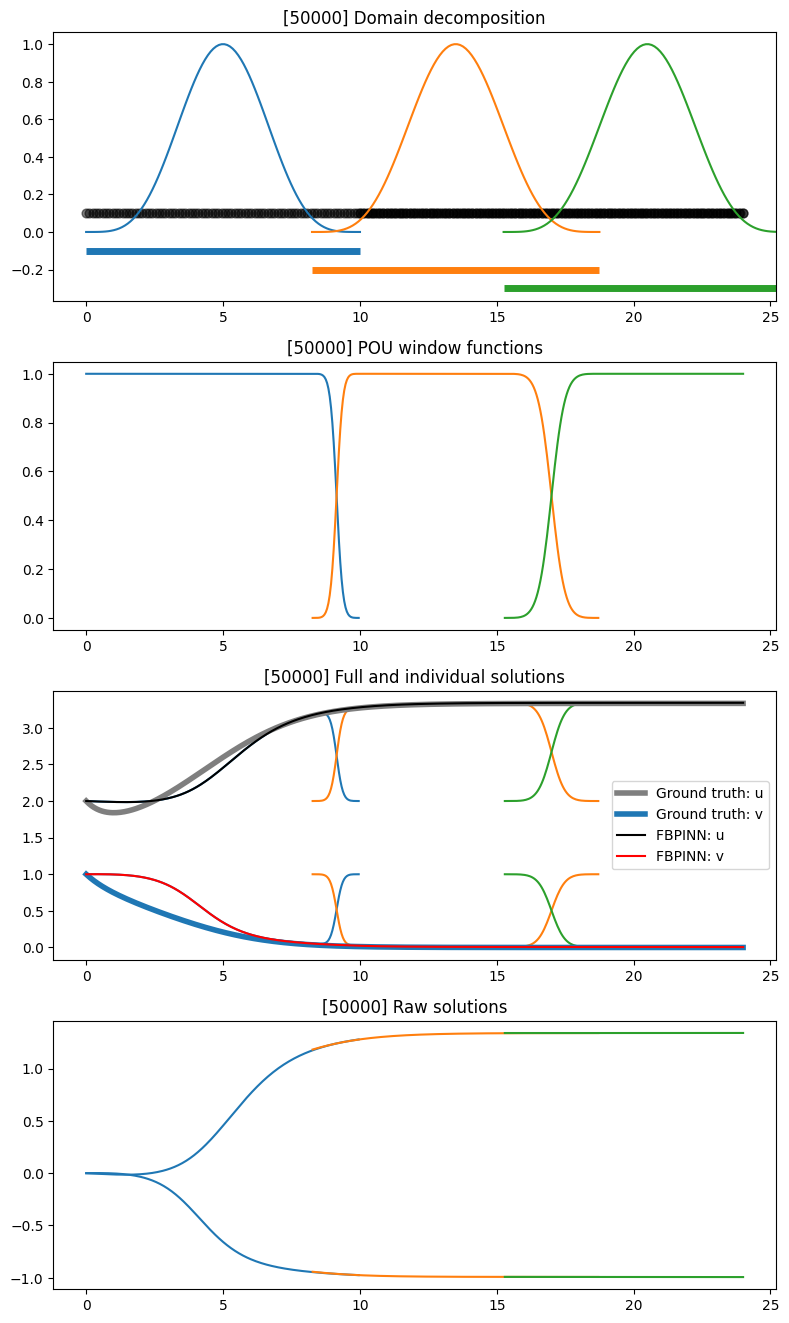

<Figure size 800x500 with 0 Axes>

[INFO] 2024-04-29 10:13:21 - [i: 50000/50000] Training complete


"\nFound the bug, it's in the $plot_trainer_1D.py$ function, \nspecifically whit _lim() and _plot_setup() functions to look into.\n\n"

In [9]:
from fbpinns.trainers import FBPINNTrainer

run = FBPINNTrainer(c)
all_params = run.train()

### TODO
"""
Found the bug, it's in the $plot_trainer_1D.py$ function, 
specifically whit _lim() and _plot_setup() functions to look into.

"""

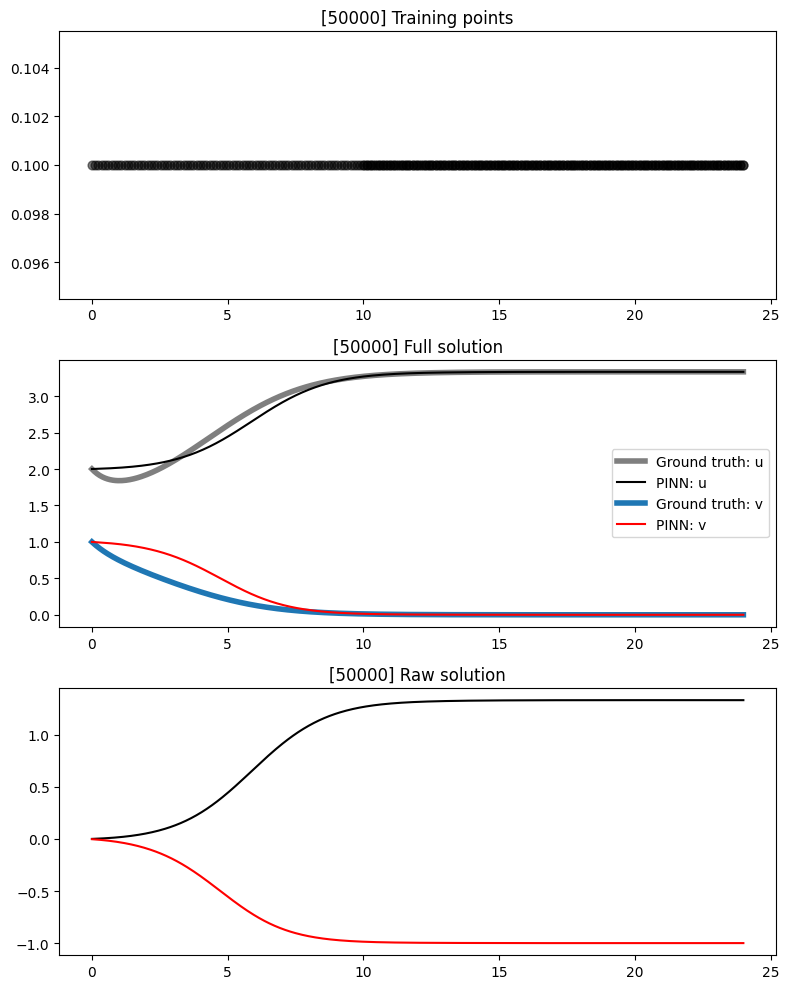

[INFO] 2024-04-29 10:13:39 - [i: 50000/50000] Training complete


In [10]:
from fbpinns.trainers import PINNTrainer
pinn_run = PINNTrainer(c)
pinn_params = pinn_run.train()

In [11]:
all_params["static"]

{'domain': {'xd': 1,
  'xmin': Array([0.], dtype=float32),
  'xmax': Array([24.], dtype=float32)},
 'problem': {'dims': (2, 1),
  'r_true': 0.5,
  'a1_true': 0.3,
  'a2_true': 0.6,
  'b1_true': 0.7,
  'b2_true': 0.3,
  'u0': 2,
  'v0': 1,
  'sd': 0.1},
 'decomposition': {'m': 3,
  'xd': 1,
  'subdomain': {'params': [Array([[-2.500e-03],
           [ 8.250e+00],
           [ 1.525e+01]], dtype=float32),
    Array([[10.0025],
           [18.75  ],
           [25.75  ]], dtype=float32),
    Array([[1.7525],
           [1.7525],
           [3.5   ]], dtype=float32),
    Array([[1.7525],
           [3.5   ],
           [3.5   ]], dtype=float32),
    Array([[1.],
           [1.],
           [1.]], dtype=float32),
    Array([[0., 1.],
           [0., 1.],
           [0., 1.]], dtype=float32)],
   'pou': Array([[0.],
          [0.],
          [0.]], dtype=float32)},
  'xmins0': array([[ 0.87375],
         [ 9.12625],
         [17.     ]]),
  'xmaxs0': array([[ 9.12625],
         [17.     ],
  

In [12]:
r, a1, a2, b1, b2 = [all_params['trainable']["problem"][key] for key in ('r', 'a1', 'a2', 'b1', 'b2')]
print(r, a1, a2, b1, b2)

r, a1, a2, b1, b2 = [all_params['static']["problem"][key] for key in ('r_true', 'a1_true', 'a2_true', 'b1_true', 'b2_true')]
print(r, a1, a2, b1, b2)

-3.5515282 0.2985557 0.41165724 0.2680843 0.46508643
0.5 0.3 0.6 0.7 0.3


In [13]:
params = all_params["trainable"]["network"]["subdomain"]["layers"]
for w, b in params[:]:
    print(w.shape, b.shape)
    #print(w)


(3, 5, 1) (3, 5)
(3, 5, 5) (3, 5)
(3, 5, 5) (3, 5)
(3, 2, 5) (3, 2)


In [14]:
import numpy as np

def _collect_weights_subdomain(all_params):
    network_params = all_params["trainable"]["network"]["subdomain"]["layers"]
    problem_params = all_params["trainable"]["problem"]
    x_values = []
    for w, b in network_params:
        x_local_w = []
        x_local_b = []
        for subdomain_weights in w:
            flattened_weights = np.array(subdomain_weights).flatten()
            # x_local_w.extend(flattened_weights)
            x_values.append(np.array(flattened_weights))
        for subdomain_biases in b:
            flattened_biases = np.array(subdomain_biases).flatten()
            # x_local_b.extend(flattened_biases)
            x_values.append(np.array(flattened_biases))

        # x_values.append(np.array(x_local_w))
        # x_values.append(np.array(x_local_b))
    param_values = np.array([float(problem_params[key]) for key in problem_params])
    x_values.append(np.array(param_values))
    return x_values

x_trained = _collect_weights_subdomain(all_params)
print(len(x_trained))

for array in x_trained:
    print(array.shape)  

25
(5,)
(5,)
(5,)
(5,)
(5,)
(5,)
(25,)
(25,)
(25,)
(5,)
(5,)
(5,)
(25,)
(25,)
(25,)
(5,)
(5,)
(5,)
(10,)
(10,)
(10,)
(2,)
(2,)
(2,)
(5,)


In [15]:
x_sizes = [x.size for x in x_trained]
num_param = sum(x_sizes)
n0 = np.split(np.random.standard_normal(num_param), np.cumsum(x_sizes))
n1 = np.split(np.random.standard_normal(num_param), np.cumsum(x_sizes))
n0

[array([1.76405235, 0.40015721, 0.97873798, 2.2408932 , 1.86755799]),
 array([-0.97727788,  0.95008842, -0.15135721, -0.10321885,  0.4105985 ]),
 array([0.14404357, 1.45427351, 0.76103773, 0.12167502, 0.44386323]),
 array([ 0.33367433,  1.49407907, -0.20515826,  0.3130677 , -0.85409574]),
 array([-2.55298982,  0.6536186 ,  0.8644362 , -0.74216502,  2.26975462]),
 array([-1.45436567,  0.04575852, -0.18718385,  1.53277921,  1.46935877]),
 array([ 0.15494743,  0.37816252, -0.88778575, -1.98079647, -0.34791215,
         0.15634897,  1.23029068,  1.20237985, -0.38732682, -0.30230275,
        -1.04855297, -1.42001794, -1.70627019,  1.9507754 , -0.50965218,
        -0.4380743 , -1.25279536,  0.77749036, -1.61389785, -0.21274028,
        -0.89546656,  0.3869025 , -0.51080514, -1.18063218, -0.02818223]),
 array([ 0.42833187,  0.06651722,  0.3024719 , -0.63432209, -0.36274117,
        -0.67246045, -0.35955316, -0.81314628, -1.7262826 ,  0.17742614,
        -0.40178094, -1.63019835,  0.46278226, 

In [16]:
norm = 2
_norm = lambda xs: np.linalg.norm(xs, norm)

In [17]:
n0_norm, n1_norm = [_norm(np.concatenate(ni)) for ni in [n0, n1]]
n0 = [ni/n0_norm for ni in n0]
n1 = [ni/n1_norm for ni in n1]
n0, n1

([array([0.11188711, 0.02538045, 0.06207762, 0.14213131, 0.11845208]),
  array([-0.06198501,  0.06026048, -0.00960001, -0.00654678,  0.0260427 ]),
  array([0.00913613, 0.09223902, 0.04826972, 0.00771738, 0.02815255]),
  array([ 0.02116369,  0.09476374, -0.01301241,  0.01985669, -0.05417203]),
  array([-0.1619264 ,  0.04145653,  0.05482789, -0.0470727 ,  0.14396188]),
  array([-0.09224487,  0.00290229, -0.01187236,  0.09721834,  0.09319582]),
  array([ 0.00982772,  0.02398541, -0.05630886, -0.12563436, -0.02206674,
          0.00991662,  0.07803264,  0.07626237, -0.02456666, -0.01917391,
         -0.06650571, -0.09006632, -0.10822221,  0.12373024, -0.03232529,
         -0.02778538, -0.07946003,  0.04931325, -0.10236338, -0.0134933 ,
         -0.05679603,  0.02453975, -0.03239842, -0.074883  , -0.00178749]),
  array([ 0.02716746,  0.00421893,  0.01918464, -0.04023263, -0.02300729,
         -0.0426516 , -0.02280509, -0.05157477, -0.10949152,  0.01125346,
         -0.02548343, -0.10339726,

In [18]:
_weight_norm = [_norm(np.concatenate(_collect_weights_subdomain(all_params)))]
_weight_norm

[7.740954939364527]

In [19]:
delta_weights = 2.0 * abs(_weight_norm[-1] - _weight_norm[0])
# loss_values = np.zeros((self._resolution**2, 3))
delta_weights

0.0

In [20]:
def collect_weights(params):
    weight_list = []
    for w, b in params:
        weight_list.append(w.flatten())
        weight_list.append(b.flatten())
    return np.concatenate(weight_list)

def norm_func(weights):
    return np.linalg.norm(weights, ord=2)

params = all_params["trainable"]["network"]["subdomain"]["layers"]
flat_weights = collect_weights(params)
_weight_norm = [norm_func(flat_weights)]

_weight_norm


[6.8382936]

In [21]:
flat_weights

array([ 0.6928692 , -1.0540549 , -0.88328904, -1.3598917 , -1.2428646 ,
       -1.3410747 ,  0.10452071, -0.24941398,  0.21513844,  0.97769046,
       -0.04149143,  0.71349865,  0.24104126, -1.0507687 ,  0.8361687 ,
        0.72965986, -0.2894475 ,  0.23463961,  0.20990734, -0.76052916,
       -0.9051847 ,  0.5795807 , -0.6706181 ,  0.53453976, -0.29718292,
        1.1160504 , -0.16675662, -1.2468771 ,  0.19829193, -1.0046026 ,
       -0.36797827, -0.17840232, -0.09929872,  0.44088385, -0.20510888,
       -0.2968518 ,  0.7751952 ,  0.5756733 ,  0.9887198 ,  0.5559105 ,
       -0.24903107, -0.49004495, -0.27101123, -0.6271237 ,  0.07292013,
        0.372723  , -0.04975369,  0.14491476, -0.5095329 ,  0.37122068,
       -0.00897281,  0.30843917, -0.44336626, -0.18708143,  0.42065075,
       -0.25154462,  0.15171655, -0.29841733,  0.13961294, -0.21793735,
       -0.3200216 ,  0.35380703, -0.4147773 ,  0.46767673, -0.02113727,
        0.5126562 , -0.62816674,  0.69705606, -0.71041065,  0.29

In [22]:
# from fbpinns.trainers import PINNTrainer

# c["network_init_kwargs"] = dict(layer_sizes=[1,5,5,5,2]) # use a larger neural network
# run = PINNTrainer(c)
# pinn_out = run.train() # start training a PINN on the same problem

In [23]:
r, a1, a2, b1, b2 = [all_params['trainable']["problem"][key] for key in ('r', 'a1', 'a2', 'b1', 'b2')]
print(r, a1, a2, b1, b2)
# r, a1, a2, b1, b2 = [pinn_out['trainable']["problem"][key] for key in ('r', 'a1', 'a2', 'b1', 'b2')]
# print(r, a1, a2, b1, b2)
r, a1, a2, b1, b2 = [all_params['static']["problem"][key] for key in ('r_true', 'a1_true', 'a2_true', 'b1_true', 'b2_true')]
print(r, a1, a2, b1, b2)

-3.5515282 0.2985557 0.41165724 0.2680843 0.46508643
0.5 0.3 0.6 0.7 0.3


In [24]:
from plot import load_FBPINN, load_PINN, exact_solution
from fbpinns.analysis import load_model

run = "test"
c, model = load_model(run, rootdir="results/")

[INFO] 2024-04-29 10:13:40 - Loading model from:
results/models/test/model_00050000.jax


In [25]:
i, all_params, all_opt_states, active, u_test_losses = model
print(c)

ValueError: not enough values to unpack (expected 5, got 4)

In [ ]:
i, all_params, all_opt_states, active, u_test_losses = model
i

In [ ]:
model[-1]

In [ ]:
i,t,l1n, loss = model[-1][:,0], model[-1][:,3], model[-1][:,-1], model[-1][:,4]
first, second = model[-1][:,1], model[-1][:, 2]
import matplotlib.pyplot as plt
# plt.plot(i, l1n, label="l1 loss")
# plt.plot(i, loss, label="loss")
# plt.plot(i, first, label="first")
#plt.plot(i, second, label="second")
plt.plot(i, t, label="t")
plt.legend()

In [ ]:
path = "results/summaries/test/"

path


In [ ]:
file_path = os.path.join(path, "params.csv")

import pandas as pd
import os
from problems import SaturatedGrowthModel

def export_parameters(c, model, file_path=None):
    all_params = model[1]  
    if c.problem==CompetitionModel:
        true_keys = ('r_true', 'a1_true', 'a2_true', 'b1_true', 'b2_true')
        learned_keys = ('r', 'a1', 'a2', 'b1', 'b2')
        true_params = [float(all_params['static']["problem"][key]) for key in true_keys]
        learned_params = [float(all_params['trainable']["problem"][key]) for key in learned_keys]
        data = {
            'Parameter': ['r', 'a1', 'a2', 'b1', 'b2'],
            'True': true_params,
            'Learned': learned_params
        }
    elif c.problem==SaturatedGrowthModel:
        true_params = [float(all_params['static']['problem']['C_true'])]
        learned_params = [float(all_params['trainable']['problem']['C'])]
        data = {
            'Parameter': ['C'],
            'True': true_params,
            'Learned': learned_params
        }
    else:
        raise ValueError("Unsupported problem type.")

    # Create DataFrame and save to CSV
    parameters_df = pd.DataFrame(data)
    if file_path is not None:
        parameters_df.to_csv(file_path, index=False)
    else:
        parameters_df.to_csv('parameters.csv', index=False)

export_parameters(c, model, file_path)

In [ ]:
all_params['static']['problem']

In [ ]:
import matplotlib.pyplot as plt
plt.plot(model[-1][:,0], model[-1][:,-1])

In [26]:
from fbpinns.analysis import FBPINN_solution, PINN_solution
all_params, domain, problem, active = model[1], c.domain, c.problem, model[3]
x_batch = domain.sample_interior(all_params=all_params, key=None, sampler="grid", batch_shape=c.n_test)
u_exact = problem.exact_solution(all_params, x_batch, batch_shape=c.n_test)
u_test = FBPINN_solution(c, all_params, active, x_batch)

KeyError: 'decomposition'

In [ ]:
u_learned = problem.learned_solution(all_params, x_batch.reshape(-1))

In [ ]:
print(np.mean((u_exact - u_test)**2))
print(np.mean((u_exact - u_learned)**2))

In [ ]:
plt.plot(x_batch, u_exact[:,0])
plt.plot(x_batch, u_exact[:,1])

plt.plot(x_batch, u_test[:,0])
plt.plot(x_batch, u_test[:,1])
plt.plot(x_batch, u_learned[:,0])
plt.plot(x_batch, u_learned[:,1])

In [ ]:
all_params['static']['domain'].keys()

Decompositon test

In [ ]:

from fbpinns.decompositions import RectangularDecompositionND
from fbpinns.constants import get_subdomain_ws

decomposition = RectangularDecompositionND # use a rectangular domain decomposition

w = 1.1
subdomain_xs = [np.array([4., 12., 20.])]
subdomain_ws = get_subdomain_ws(subdomain_xs, w)
unnorm = (0., 1.)
decomposition_init_kwargs = dict(
    subdomain_xs = subdomain_xs,
    # subdomain_ws = [(24/1.8)*np.ones((2,))],
    subdomain_ws = get_subdomain_ws(subdomain_xs, w),
    unnorm = (0., 1.),
)
decomposition_init_kwargs


In [ ]:
subdomain_xs
nm = tuple([len(x) for x in subdomain_xs])
print(f"nm={nm}")
m = np.prod(nm)
print(f"m={m}")
xd = len(subdomain_xs)
print(f"xd={xd}")

In [ ]:
ps = RectangularDecompositionND._get_level_params(0, xd, subdomain_xs, subdomain_ws, unnorm)
print(f"ps={ps}")

In [ ]:
xmins0, xmaxs0 = (ps[0]+ps[2]/2), (ps[1]-ps[3]/2)
print(xmins0, xmaxs0)

In [ ]:
from jax import vmap, tree_map
params = tree_map(lambda x: jnp.array(x), ps)
static_params = {
            "m":m,
            "xd":xd,
            "subdomain":{"params":params[:-1],# use special key for subdomain parameters
                         "pou":params[-1]},
            "xmins0":xmins0,
            "xmaxs0":xmaxs0,
            }
static_params

In [ ]:
#1D test
subdomain_xs = [np.linspace(-3,3,4),]
subdomain_ws = [3*np.ones(4),]

decomposition = RectangularDecompositionND
ps_ = decomposition.init_params(subdomain_xs, subdomain_ws, (0,1))
all_params = {"static":{"decomposition":ps_[0]}, "trainable":{"decomposition":ps_[1]}}
m = all_params["static"]["decomposition"]["m"]
active = np.ones(m)

active[1] = 0
active[2] = 2
print(subdomain_xs, subdomain_ws, ps_ , all_params, m, active)

In [ ]:
decomposition.plot(all_params, active=active, show_norm=True, show_window=True)

In [ ]:
x_batch = np.array([[-2],
                        [1],
                        [3],
                        [4.7]])
for x in x_batch:
    plt.scatter(x[0], 0.5)
plt.show()
print(decomposition.inside_models(all_params, x_batch, np.arange(m)))
print(decomposition.inside_points(all_params, x_batch))

In [ ]:
subdomain_xs = [np.array([0])]
subdomain_ws = [np.array([1])]

decomposition = RectangularDecompositionND
ps_ = decomposition.init_params(subdomain_xs, subdomain_ws, (0,1))
all_params = {"static":{"decomposition":ps_[0]}, "trainable":{"decomposition":ps_[1]}}

decomposition.plot(all_params)
plt.show()


### Create custom domain Decomposition

In [ ]:
t_end, t_begin = 24, 0
time_limit = [10, 20]
num_subdomain = 2
ww = 1.1


In [27]:
data_start, data_end = time_limit
subdomains = []
centers = []

# Determine if there are valid no-data regions
has_no_data_at_start = data_start > t_begin
has_no_data_at_end = data_end < t_end

# Handle no-data region at the start

if has_no_data_at_start:
    subdomains.append((t_begin, data_start))
    centers.append((t_begin + data_start) / 2)

# Handle no-data region at the end
if has_no_data_at_end:
    subdomains.append((data_end, t_end))
    centers.append((data_end + t_end) / 2)

# Calculate remaining subdomains
remaining_subdomains = num_subdomain - len(subdomains)

# Divide the data region into subdomains, if there are remaining subdomains to allocate
if remaining_subdomains > 0:
    # Calculate length of each subdomain within the data region
    each_subdomain_length = (data_end - data_start) / remaining_subdomains
    for i in range(remaining_subdomains):
        start = data_start + i * each_subdomain_length
        end = start + each_subdomain_length
        # Adjust for overlapping if necessary, and avoid exceeding domain limits
        # if i != 0:  # Overlap, except for the first subdomain
        #     start -= ww
        subdomains.append((start, end))
        centers.append((start + end) / 2)
else:
    # If no remaining subdomains, consider the entire data region as one subdomain
    subdomains.append((data_start, data_end))
    centers.append((data_start + data_end) / 2)

subdomain_xs = [np.array(np.sort(centers))]
subdomain_ws = [np.array([np.diff(sub)*ww for _, sub in sorted(zip(centers, subdomains))]).flatten()]
print(subdomain_ws, subdomain_xs)

NameError: name 'time_limit' is not defined

In [ ]:
from fbpinns.decompositions import RectangularDecompositionND
from fbpinns.constants import get_subdomain_ws

decomposition = RectangularDecompositionND # use a rectangular domain decomposition

#subdomain_xs = [np.linspace(0,24,3)]
decomposition_init_kwargs = dict(
    subdomain_xs = subdomain_xs,
    # subdomain_ws = [(24/1.8)*np.ones((2,))],
    # subdomain_ws = get_subdomain_ws(subdomain_xs, w),
    subdomain_ws = subdomain_ws,
    unnorm = (0., 1.),
)
decomposition_init_kwargs

In [ ]:
decomposition = RectangularDecompositionND
ps_ = decomposition.init_params(subdomain_xs, subdomain_ws, (0,1))
all_params = {"static":{"decomposition":ps_[0]}, "trainable":{"decomposition":ps_[1]}}
m = all_params["static"]["decomposition"]["m"]
active = np.ones(m)
active[0] = 0
f = decomposition.plot(all_params, active=active, show_norm=True, show_window=True, create_fig=True)

In [ ]:
from IPython.display import display
f.suptitle(f"time_limit:{time_limit}")
display(f)


In [ ]:

def get_subdomain_ws(subdomain_xs, width):
    return [width*np.min(np.diff(x))*np.ones_like(x) for x in subdomain_xs]
subdomain_xs

In [ ]:
[np.min(np.diff(x))*np.ones_like(x) for x in subdomain_xs]

In [ ]:
x_batch_data = jnp.linspace(0, 24, 50).astype(float).reshape((-1,1))
r_true, a1_true, a2_true, b1_true, b2_true = [all_params['static']["problem"][key] for key in ('r_true', 'a1_true', 'a2_true', 'b1_true', 'b2_true')]
params = (r_true, a1_true, a2_true, b1_true, b2_true)
solution = odeint(CompetitionModel.model, [2,1], x_batch_data.reshape((-1,)), args=(params,))

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(x_batch_data, solution[:,0:1])
plt.scatter(x_batch_data, solution[:,1:2])

Sampler 101

c:\Users\tirth\anaconda3\envs\fbpinns2\Lib\site-packages\scipy\stats\_qmc.py:958: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  sample = self._random(n, workers=workers)


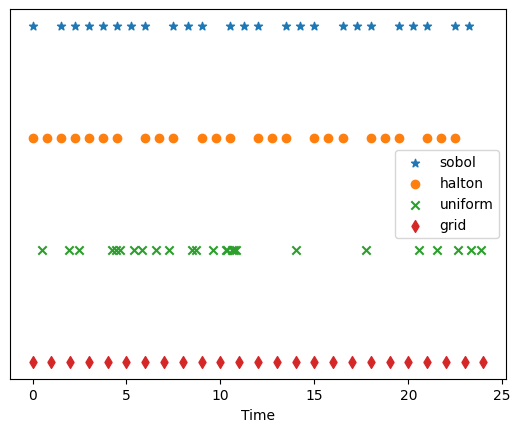

In [36]:
import scipy.stats
import jax
from jax import random
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt

def get_sampling(sampler="grid"):
    xd = 1
    xmin = 0
    xmax = 24
    batch_shape = 25
    key = random.PRNGKey(0)

    if sampler == "grid":
        x_batch = jnp.linspace(xmin, xmax, batch_shape).reshape((-1, xd))
    else:
        if sampler == "halton":
            r = scipy.stats.qmc.Halton(d=xd, scramble=False)
            s = r.random(n=batch_shape)
        elif sampler == "sobol":
            r = scipy.stats.qmc.Sobol(d=xd, scramble=False)
            s = r.random(n=batch_shape)
        elif sampler == "uniform":
            s = random.uniform(key, (batch_shape, xd))

        x_batch = xmin + (xmax - xmin) * s

    return jnp.array(x_batch)

x_grid = get_sampling(sampler='grid')
x_halton = get_sampling(sampler='halton')
x_sobol = get_sampling(sampler='sobol')
x_uniform = get_sampling('uniform')

plt.scatter(x_sobol, np.ones_like(x_grid)+1.5, marker='*', label='sobol')
plt.scatter(x_halton,  np.ones_like(x_grid)+1, marker='o', label='halton')
plt.scatter(x_uniform,  np.ones_like(x_grid)+0.5, marker='x', label='uniform')
plt.scatter(x_grid, np.ones_like(x_grid), marker='d', label='grid')


plt.yticks([])  # Hide y-axis ticks
# set y label as Time
plt.xlabel("Time")
plt.gca().axes.get_yaxis().set_visible(False)  # Optionally, make y-axis completely invisible
plt.legend()
plt.savefig("sampling.png")
plt.show()

In [ ]:
def model(y, t, params):
        """
        Compute the derivatives of the system at time t.
        
        :param y: Current state of the system [u, v].
        :param t: Current time.
        :param params: Parameters of the model (a1, a2, b1, b2, r).
        :return: Derivatives [du/dt, dv/dt].
        """
        u, v = y  
        r, a1, a2, b1, b2 = params  
        
        # Define the equations
        du_dt = u * (1 - a1 * u - a2 * v)
        dv_dt = r * v * (1 - b1 * u - b2 * v)
        
        return [du_dt, dv_dt]

def solve_ode(initial_conditions, t_span):
        """
        Solves the ODE using scipy's ````odeint````.
        """
        solution = odeint(model, initial_conditions, t_span)
        return t_span, solution
u0 = 2
v0= 1
params = [0.5, 0.7, 0.3, 0.3, 0.6]
t = np.arange(0, t_end+.0001, 0.0002)
solution = odeint(model, [u0,v0], t, args=(params,))
solution.shape

In [ ]:
t_test  = np.linspace(10,24,50)
u_interp = interp1d(t, solution[:, 0], kind='slinear')
v_interp = interp1d(t, solution[:, 1], kind='slinear')

In [ ]:
u_data = u_interp(t_test.flatten())

In [ ]:
u_data

In [ ]:
plt.plot(t_test, u_data, label="test")
plt.plot(t, solution[:,0], label='true')
plt.legend()

In [ ]:
sol = odeint(model, [u0,v0], t_test, args=(params,))
plt.plot(t_test, sol[:,0], label="u")
plt.plot(t_test, sol[:,1], label="v")
plt.legend()
plt.xlim(0,24)
plt.ylim(0,2.5)
plt.show()
